In [8]:
!pip install ordpy
import numpy as np
import ordpy
from ordpy import renyi_entropy
from ordpy import permutation_entropy
from ordpy import renyi_complexity_entropy
from ordpy import minimum_complexity_entropy
from ordpy import maximum_complexity_entropy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import string
import glob
import warnings
import math
from scipy.fft import fft, ifft
from scipy.io import savemat
import matplotlib.colors as mcolors


In [9]:
def maximum_renyi_complexity_entropy(dx=3, dy=1, m=1, q=1.4):
    """
    Generates data corresponding to values of normalized renyi permutation
    entropy and statistical complexity which delimit the upper boundary in the
    complexity-entropy renyi causality plane\\ [#rosso_curvas]_:sup:`,`\\ [*]_.

    Parameters
    ----------
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); must be 1 for time series
         (default: 1).
    m : int
        The length of the returned array containing values of permutation entropy
        and statistical complexity is given by
        :math:`[(d_x \\times d_y)!-1] \\times m`.
    q:  float
        Renyi parameter (default: 1.4)

    Returns
    -------
     : array
       Values of normalized permutation renyi entropy and statistical complexity
       belonging to the upper limiting curve of the renyi complexity-entropy causality
       plane.

    Notes
    -----
    .. [*] This function was adapted from Ordpy.

    """
    if q==1.0:
       return maximum_complexity_entropy(dx,dy,m)
    else:
       N              = math.factorial(dx*dy)
       hlist_, clist_ = np.zeros(shape=(N-1,m)), np.zeros(shape=(N-1,m))
       for i in range(N-1):
           p             = np.zeros(shape=N)
           uniform_dist  = np.full(N, 1/N)
           prob_params   = np.linspace(0, 1/N, num=m)
           for k in range(len(prob_params)):
               p[0] = prob_params[k]
               for j in range(1,N-i):
                   p[j] = (1-prob_params[k])/(N-i-1)
               h = renyi_entropy(p,q,dx, dy, probs=True)
               p_plus_u_over_2      = (uniform_dist + p)/2
               s_of_p_plus_u_over_2 = renyi_entropy(p_plus_u_over_2,q,dx, dy, probs=True)
               p_non_zero    = p[p!=0]
               p_plus_u_over_2_no      = (1/N + p_non_zero)/2
               t_1=np.log(sum((p**q)*p_plus_u_over_2**(1-q)))
               t_2=np.log(sum((uniform_dist**q)*p_plus_u_over_2**(1-q)))
               js_div_max = (0.5/(q-1))*np.log((((N+1)**(1-q)+N-1)/N)*((N+1)/(4*N))**(1-q))
               js_div     = (0.5/(q-1))*(t_1+t_2)
               hlist_[i, k] = h
               clist_[i, k] = h*js_div/js_div_max

       #flatenning the arrays and ordering the pairs of values.
       hlist_ = hlist_.flatten()
       clist_ = clist_.flatten()
       args   = np.argsort(hlist_)

    return np.asarray((hlist_[args], clist_[args])).T

In [10]:
def minimum_renyi_complexity_entropy(dx=3, dy=1, size=100,q=1.4):
    """
    Generates data corresponding to values of normalized renyi permutation
    entropy and statistical complexity which delimit the lower boundary in the
    complexity-entropy renyi causality plane\\ [#rosso_curvas]_:sup:`,`\\ [*]_.

    Parameters
    ----------
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); must be 1 for time series
         (default: 1).
    size : int
           The length of the array returned containing pairs of values of
           permutation entropy and statistical complexity.
    q:  float
        Renyi parameter (default: 1.4)

    Returns
    -------
     : array
       Values of normalized permutation renyi entropy and statistical complexity
       belonging to the lower limiting curve of the renyi complexity-entropy
       causality plane.

    Notes
    -----
    .. [*] This function was adapted from Ordpy.

    """
    if q==1.0:
       return minimum_complexity_entropy(dx,dy,size)
    else:
       size        += 1
       N            = math.factorial(dx*dy)
       prob_params  = np.linspace(1/N, 1, num=size-1)
       uniform_dist = np.full(N, 1/N)
       hc_ = []
       for i in range(size-1):
           probabilities    = np.full(shape=N, fill_value=(1-prob_params[i])/(N-1))
           probabilities[0] = prob_params[i]
           h = renyi_entropy(probabilities,q,dx, dy, probs=True)
           p_plus_u_over_2      = (uniform_dist + probabilities)/2
           s_of_p_plus_u_over_2 = renyi_entropy(p_plus_u_over_2,q,dx, dy, probs=True)
           # probabilities = probabilities[probabilities!=0]

           t_1=np.log(sum((probabilities**q)*p_plus_u_over_2**(1-q)))
           t_2=np.log(sum((uniform_dist**q)*p_plus_u_over_2**(1-q)))

           js_div_max = (0.5/(q-1))*np.log((((N+1)**(1-q)+N-1)/N)*((N+1)/(4*N))**(1-q))
           js_div     = (0.5/(q-1))*(t_1+t_2)


           hc_.append([h, h*js_div/js_div_max])

       return np.flip(hc_, axis=0)

In [11]:
D=3
num_rows = 15
alpha_max = 5
step = alpha_max / num_rows
num_values = int(alpha_max / step) + 1   # Number of values in the vector
alpha_range = np.logspace(0, np.log10(alpha_max), num_values)
q_values = np.arange(0.2, 7.0, 0.2)
q_values = q_values[q_values != 1.0]  # Filter the array to exclude the value 1

# Length of each time series
length = 10000

# Function to generate Henon map series and average its components
def generate_henon_map_averaged(length, a, b):
    x = np.zeros(length)
    y = np.zeros(length)

    for t in range(1, length):
        x[t] = 1 - a * x[t - 1] ** 2 + y[t - 1]
        y[t] = b * x[t - 1]

    # Average the two components to create a single time series
    averaged_series = (x + y) / 2.0

    return averaged_series


# Logistic map parameters
r = 4
# Initialization
x = np.zeros(100000)
x[0] = 0.1

# Generate the series using the logistic map
for t in range(1, len(x)):
    x[t] = r * x[t-1] * (1 - x[t-1])


# Function to generate white noise series
def generate_white_noise(length):
    return np.random.randn(length)


# Matrix to store the time series
knoise_matrix = np.zeros((num_rows, length))
entropy = np.zeros(num_rows)
complexity = np.zeros(num_rows)


# Iterate through each row and generate a time series
for i in range(num_rows):
    # Select a random value of alpha within the specified range
    alpha = alpha_range[i]

    # Generate a time series of 1/|f|^(alpha) colored noise
    knoise_series = np.real(ifft(fft(np.random.randn(length)) * (1 / np.arange(1, length + 1) ** (alpha))))

    # Add the time series to the matrix
    knoise_matrix[i, :] = knoise_series


def schuster_map(x0, z, num_steps):
    """
    Calculate a time series using the Schuster map.

    Args:
        x0 (float): Initial value of x.
        z (float): Parameter z (must be 2, 2.5, or 3).
        num_steps (int): Number of time steps to generate the time series.

    Returns:
        List[float]: List of values of the generated time series.
    """
    x_values = []
    x = x0

    for _ in range(num_steps):
        x = (x + x ** z) % 1
        x_values.append(x)

    return x_values

# Generate schuster series
x0 = 0.1  # Initial value of x
z_values = [3/2,2,5/2]  # z values

# Generate white noise series
white_noise = generate_white_noise(100000)

# Generate Henon map series and average its components
henon_map_averaged = generate_henon_map_averaged(100000, a=1.4, b=0.3)

################################################################################
# Calculate Renyi Complexity and Entropy for the new series
################################################################################
schus_RE = np.zeros((3,len(q_values)))  # Initialize an ndarray with three elements to store e values
schus_RC = np.zeros((3,len(q_values)))  # Initialize an ndarray with three elements to store c values
map_RE = np.zeros(len(q_values))
map_RC = np.zeros(len(q_values))
white_noise_RE= np.zeros(len(q_values))
white_noise_RC= np.zeros(len(q_values))
henon_map_averaged_RE= np.zeros(len(q_values))
henon_map_averaged_RC= np.zeros(len(q_values))
k_noise_RE = np.zeros((num_rows,len(q_values)))
k_noise_RC = np.zeros((num_rows,len(q_values)))

for i in [0,1,2]:
    schus_series = schuster_map(x0, z_values[i], length)
    index=0
    for q in q_values:
        e , c = renyi_complexity_entropy(schus_series, q, D, 1)
        schus_RE[i,index] = e
        schus_RC[i,index] = c
        index=index+1

index=0
for q in q_values:
    map_RE[index],map_RC[index] =  renyi_complexity_entropy(x,q,D, 1)
    white_noise_RE[index], white_noise_RC[index] = renyi_complexity_entropy(white_noise, q, D, 1)
    henon_map_averaged_RE[index], henon_map_averaged_RC[index] = renyi_complexity_entropy(henon_map_averaged, q, D, 1)
    index=index+1

for i in  range(num_rows):
    knoise_series=knoise_matrix[i, :]
    index=0
    for q in q_values:
        e,c =renyi_complexity_entropy(knoise_series, q, D, 1)
        k_noise_RE[i,index] = e
        k_noise_RC[i,index] = c
        index=index+1


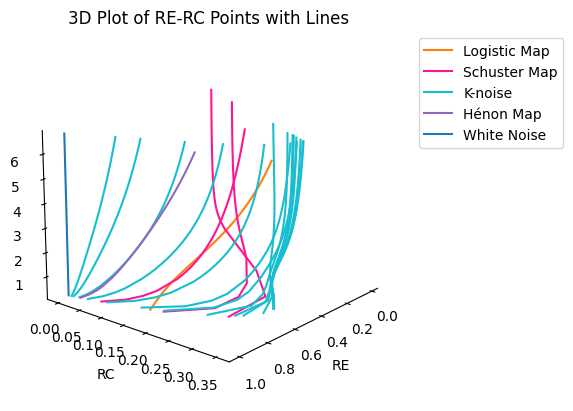

In [12]:
# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Connect points with lines
ax.plot(map_RE, map_RC, q_values, color='tab:orange', label='Logistic Map')
for i in range(3):
    if i == 0:
        ax.plot(schus_RE[i], schus_RC[i], q_values, color='deeppink', label='Schuster Map')
    else:
        ax.plot(schus_RE[i], schus_RC[i], q_values, color='deeppink')

for i in range(num_rows):
    if i == 0:
        ax.plot(k_noise_RE[i], k_noise_RC[i], q_values, color='tab:cyan', label='K-noise')
    else:
        ax.plot(k_noise_RE[i], k_noise_RC[i], q_values, color='tab:cyan')

ax.plot(henon_map_averaged_RE, henon_map_averaged_RC, q_values, color='tab:purple', label='Hénon Map')
ax.plot(white_noise_RE, white_noise_RC, q_values, color='tab:blue', label='White Noise')

# Customize the plot
ax.set_xlabel('RE')
ax.set_ylabel('RC')
ax.set_zlabel('q_values')
ax.set_title('3D Plot of RE-RC Points with Lines')

# Remove accessory lines
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

# Change background color to white
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Enable missing axes
ax.box_on = True  # Show the "box" representing the axes

ax.view_init(elev=20, azim=40)  # Adjust elevation and azimuth angles to rotate the plot

# Show the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

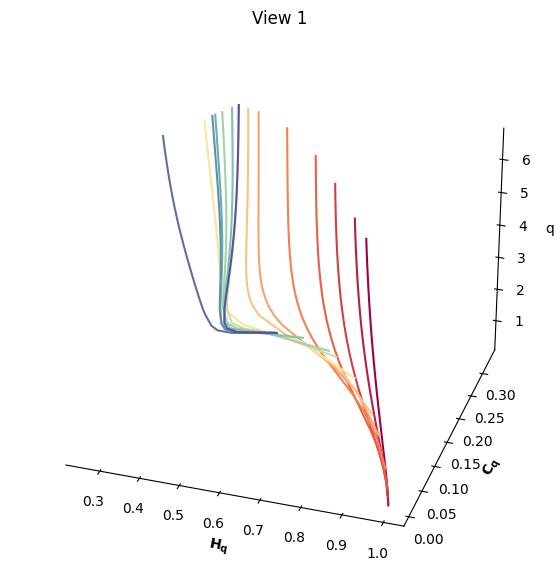

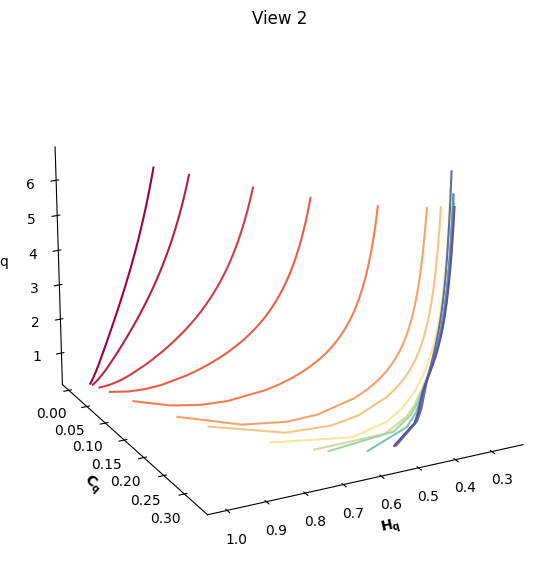

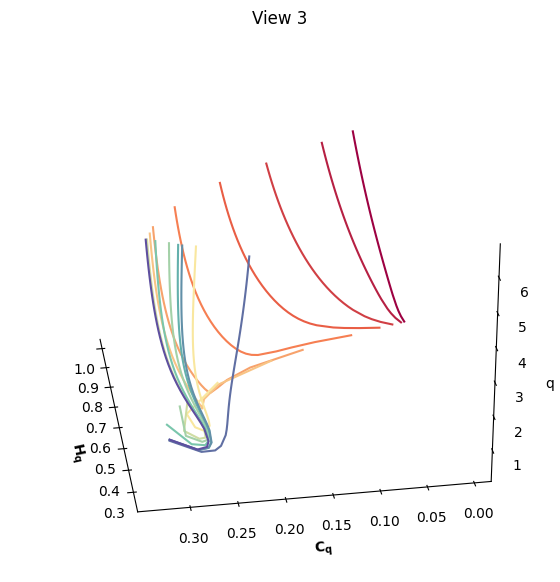

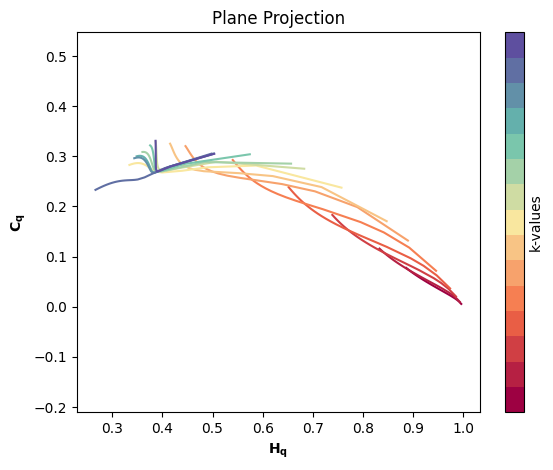

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings("ignore")

# Define the number of colors in the custom colormap
num_colors = 15

# Control points in the custom colormap
control_points = [0, .25, .5, .75, 1]

# Colors corresponding to the control points
colors = [
    [157/255, 1/255, 66/255],     # Color 1: #9d0142 in RGB format
    [246/255, 110/255, 69/255],   # Color 2: #f66e45 in RGB format
    [249/255, 231/255, 159/255],  # Color 3: #ffffbb in RGB format
    [101/255, 192/255, 174/255],  # Color 4: #65c0ae in RGB format
    [94/255, 79/255, 159/255]     # Color 5: #5e4f9f in RGB format
]

# Create the custom colormap
cmap = LinearSegmentedColormap.from_list("custom", list(zip(control_points, colors)), N=num_colors)

# Define the views (viewing angles)
views = [[-72.00, 29.6], [62.8, 21.6], [170.8, 28]]

# Create subplots for each view
for i, view in enumerate(views):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Connect points with lines
    for j in range(num_rows):
        ax.plot(k_noise_RE[j], k_noise_RC[j], q_values, color=cmap(j / num_rows))

    # Customize the plot
    ax.set_xlabel(r'$\mathbf{H_q}$')
    ax.set_ylabel(r'$\mathbf{C_q}$')
    ax.set_zlabel('q')
    ax.set_title(f'View {i+1}')

    # Adjust elevation and azimuth angles to rotate the plot
    ax.view_init(elev=view[1], azim=view[0])

    # Remove accessory lines
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)

    # Change background color to white
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Enable missing axes
    # ax.box_on = True  # Show the "box" representing the axes
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()

# Create an additional figure for the plane projection
fig = plt.figure(figsize=(6, 6))
ax2 = fig.add_subplot(111)

# Draw projected points on the plane
for j in range(num_rows):
    ax2.plot(k_noise_RE[j], k_noise_RC[j], color=cmap(j / num_rows))

# Customize the plot
ax2.set_xlabel(r'$\mathbf{H_q}$')
ax2.set_ylabel(r'$\mathbf{C_q}$')
ax2.set_title('Plane Projection')
# Set equal aspect ratio
ax2.set_aspect('equal', adjustable='datalim')
# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap)
cbar = plt.colorbar(sm)
# Change color bar labels
cbar.set_label('k-values')
cbar.set_ticks([])
plt.tight_layout(rect=[0, 0, 1, 0.8])
plt.show()

